In [24]:
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

FILE = "insurance.csv"

df_raw = pd.read_csv(FILE)

print(df_raw.head(2))

print()
print(df_raw.isna().sum())

print()
print(df_raw['sex'].value_counts())

print()
print(df_raw['smoker'].value_counts())

print()
print(df_raw['region'].value_counts())

   age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

sex
male      676
female    662
Name: count, dtype: int64

smoker
no     1064
yes     274
Name: count, dtype: int64

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [25]:
val_map = {"female":1, "male": 0, "yes":1, "no":0}
# we'll encode male/female and nonsmoker/smoker as binary 0/1
df_raw = df_raw.replace(to_replace=val_map)

# one-hot encoding for region
df_raw = pd.concat([df_raw, pd.get_dummies(df_raw['region'], dtype=float, prefix='region')], axis=1)
df_raw = df_raw.drop('region', axis=1)

print(df_raw.head(2))

   age sex    bmi  children smoker     charges  region_northeast  \
0   19   1  27.90         0      1  16884.9240               0.0   
1   18   0  33.77         1      0   1725.5523               0.0   

   region_northwest  region_southeast  region_southwest  
0               0.0               0.0               1.0  
1               0.0               1.0               0.0  


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_raw.to_numpy()), columns=df_raw.columns.to_list())

print(df_scaled.head(2))

        age       sex       bmi  children    smoker   charges  \
0 -1.438764  1.010519 -0.453320 -0.908614  1.970587  0.298584   
1 -1.509965 -0.989591  0.509621 -0.078767 -0.507463 -0.953689   

   region_northeast  region_northwest  region_southeast  region_southwest  
0         -0.565267         -0.566418         -0.611324          1.765481  
1         -0.565267         -0.566418          1.635795         -0.566418  


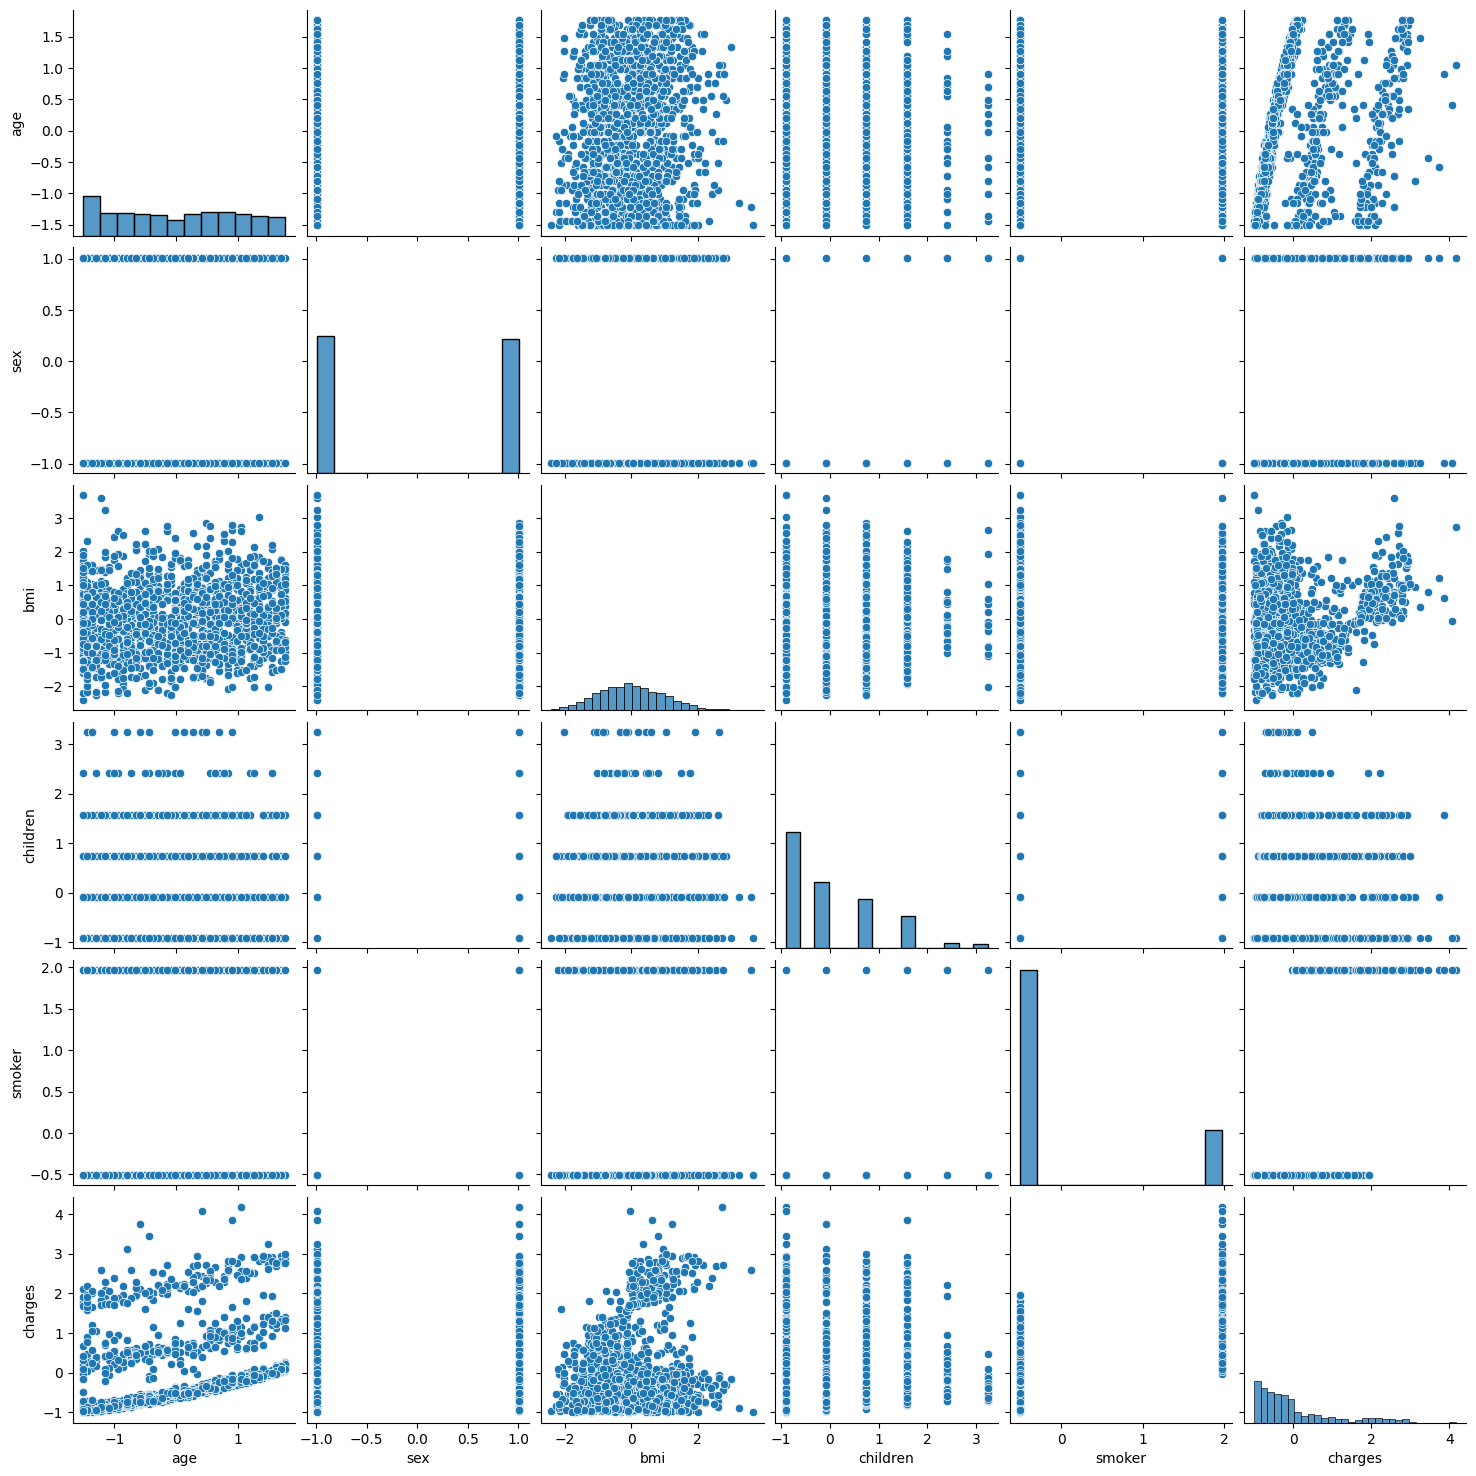

In [91]:
import seaborn as sns
sns.pairplot(df_scaled[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']])

sex                -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
children            0.067998
region_southeast    0.073982
bmi                 0.198341
age                 0.299008
smoker              0.787251
charges             1.000000
dtype: float64


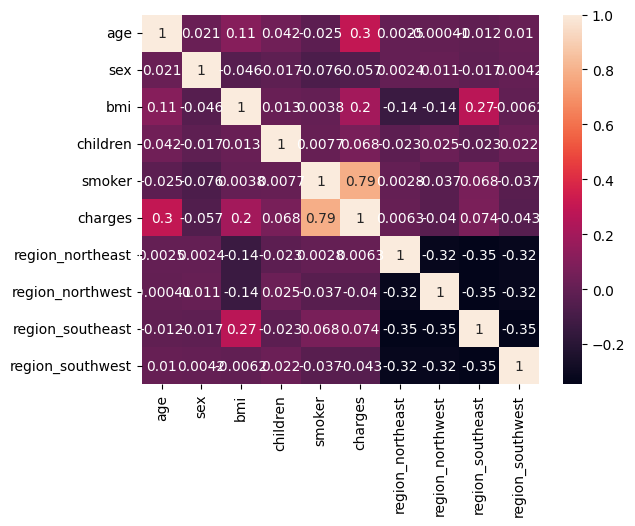

In [92]:
sns.heatmap(df_scaled.corr(), annot=True)
print(df_scaled.corrwith(df_scaled['charges']).sort_values())

<Axes: >

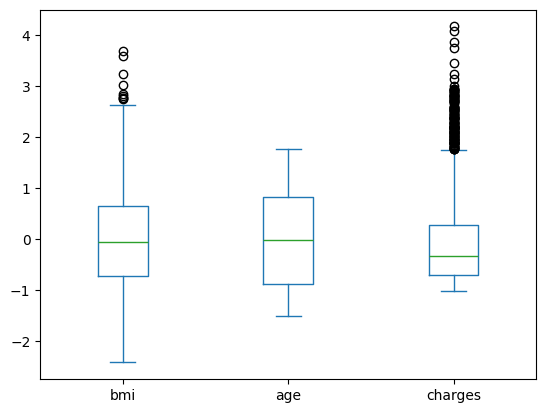

In [93]:
df_scaled[['bmi', 'age', 'charges']].plot.box()

<Axes: >

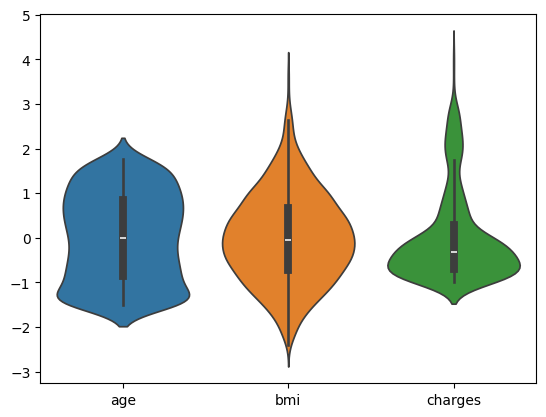

In [94]:
sns.violinplot(df_scaled[['age', 'bmi', 'charges']])

<Axes: xlabel='age', ylabel='bmi'>

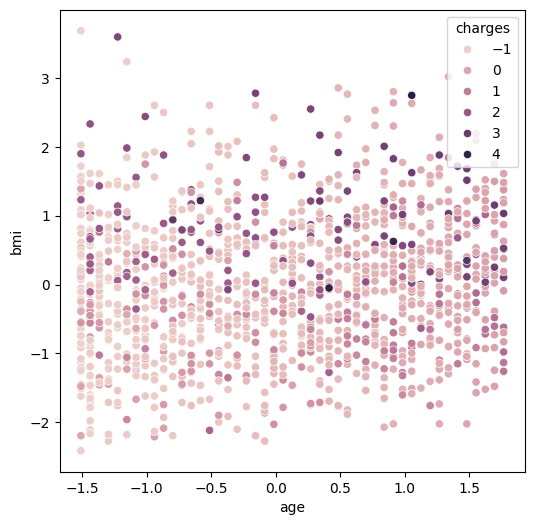

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=df_scaled['age'], y=df_scaled['bmi'], hue=df_scaled['charges'])

In [96]:
from sklearn.model_selection import train_test_split
target = 'charges'

df_train, df_valid_test = train_test_split(df_scaled, test_size=0.2, random_state=0)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=0)

y_train, y_valid, y_test = df_train[target], df_valid[target], df_test[target]
X_train, X_valid, X_test = df_train.drop(target, axis=1), df_valid.drop(target, axis=1), df_test.drop(target, axis=1)

In [97]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

best_score = 0
best_depth = 0
best_dtr = None
for d in range(1,6):
    dtr = DecisionTreeRegressor(max_depth=d).fit(X_train, y_train)
    score = dtr.score(X_valid, y_valid)
    if score > best_score:
        best_score, best_depth, best_dtr = score, d, dtr

print("DECISION TREE VALIDATION: the best R2 score was %f with max_depth=%d"%(best_score, best_depth))
test_score = best_dtr.score(X_test, y_test)
print("DECISION TREE TESTING: the best R2 score was %f with max_depth=%d"%(test_score, best_depth))
y_pred = best_dtr.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
print("DECISION TREE TESTING: mean absolute error =",mae)
print("DECISION TREE TESTING: mean squared error =",mse)

results = [{'Regressor':'Decision Tree', 'R2 Score':test_score, 'MAE':mae, 'MSE':mse}]

DECISION TREE VALIDATION: the best R2 score was 0.943215 with max_depth=3
DECISION TREE TESTING: the best R2 score was 0.819518 with max_depth=3
DECISION TREE TESTING: mean absolute error = 0.256534330450947
DECISION TREE TESTING: mean squared error = 0.1943181897382851


In [98]:
from sklearn.svm import SVR

best_score = 0
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_kernel = 'rbf'
best_svr = None
for k in kernels:
    svr = SVR(kernel=k).fit(X_train, y_train)
    score = svr.score(X_valid, y_valid)
    if score > best_score:
        best_score, best_kernel, best_svr = score, k, svr

print("SVR VALIDATION: the best R2 score was %f with kernel=%s"%(best_score, best_kernel))
test_score = best_svr.score(X_test, y_test)
print("SVR TESTING: the best R2 score was %f with kernel=%s"%(test_score, best_kernel))
y_pred = best_svr.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
print("SVR TESTING: mean absolute error =",mae)
print("SVR TESTING: mean squared error =",mse)

results.append({'Regressor':'SVR', 'R2 Score':test_score, 'MAE':mae, 'MSE':mse})

SVR VALIDATION: the best R2 score was 0.943936 with kernel=rbf
SVR TESTING: the best R2 score was 0.829302 with kernel=rbf
SVR TESTING: mean absolute error = 0.24742540115134223
SVR TESTING: mean squared error = 0.18378434318814427


In [99]:
from sklearn.ensemble import RandomForestRegressor

best_score = 0
best_n = 0
best_depth = 0
best_regressor = None
for n in range(2,11):
    for d in range(1,6):
        regressor = RandomForestRegressor(n_estimators=n, max_depth=d).fit(X_train, y_train)
        score = regressor.score(X_valid, y_valid)
        if score > best_score:
            best_score, best_n, best_depth, best_regressor = score, n, d, regressor

print("RANDOM FOREST VALIDATION: the best R2 score was %f with n_estimators=%d and max_depth=%d"%(best_score, best_n, best_depth))
test_score = best_regressor.score(X_test, y_test)
print("RANDOM FOREST TESTING: the best R2 score was %f with n_estimators=%d and max_depth=%d"%(test_score, best_n, best_depth))
y_pred = best_regressor.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
print("RANDOM FOREST TESTING: mean absolute error =",mae)
print("RANDOM FOREST TESTING: mean squared error =",mse)

results.append({'Regressor':'Random Forest', 'R2 Score':test_score, 'MAE':mae, 'MSE':mse})

RANDOM FOREST VALIDATION: the best R2 score was 0.952010 with n_estimators=6 and max_depth=4
RANDOM FOREST TESTING: the best R2 score was 0.846724 with n_estimators=6 and max_depth=4
RANDOM FOREST TESTING: mean absolute error = 0.23354948351613372
RANDOM FOREST TESTING: mean squared error = 0.1650262722709556


In [100]:
df_results = pd.DataFrame(results)
df = df_results.set_index('Regressor')
print(df)

               R2 Score       MAE       MSE
Regressor                                  
Decision Tree  0.819518  0.256534  0.194318
SVR            0.829302  0.247425  0.183784
Random Forest  0.846724  0.233549  0.165026
